#  Normalizing Flows

You may choose your own way to implement a normalizing flow. However, this is our recommended recipe for implementing one:

In [1]:
#@title tools
from torch.utils import data
import torch


class MyDataset(data.Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class ConditionalDataset(data.Dataset):
    def __init__(self, x, y, d=None):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


# region: Conditional Helpers


def generate_points_on_ring(center, radius, thickness, num_points) -> np.ndarray:
    points = []
    while len(points) < num_points:
        r = np.random.uniform(radius - thickness / 2, radius + thickness / 2)
        theta = np.random.uniform(0, 2 * np.pi)
        x = center[0] + r * np.cos(theta)
        y = center[1] + r * np.sin(theta)
        points.append((x, y))
    return points


def sample_olympic_rings(num_points_per_ring, ring_thickness=0.1):
    centers = [(0, 0), (2, 0), (4, 0), (1, -1), (3, -1)]
    colors = ["blue", "black", "red", "yellow", "green"]
    radius = 1
    all_points = []
    all_labels = []

    for center, color in zip(centers, colors):
        points = generate_points_on_ring(
            center, radius, ring_thickness, num_points_per_ring
        )
        labels = [color] * num_points_per_ring
        all_points.extend(points)
        all_labels.extend(labels)

    return all_points, all_labels


# endregion: Conditional Helpers

# region: Unconditional Helpers


def point_in_ring(x, y, center, radius, thickness):
    distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    return radius - thickness / 2 <= distance <= radius + thickness / 2


def generate_points_on_rings__unconditional(centers, radius, thickness, num_points):
    points = []
    count = 0
    while count < num_points:
        x = np.random.uniform(-1, 5)
        y = np.random.uniform(-2, 1)
        in_any_ring = False
        for center in centers:
            if point_in_ring(x, y, center, radius, thickness):
                in_any_ring = True
                break
        if in_any_ring:
            points.append((x, y))
            count += 1
    return points


# endregion: Unconditional Helpers


def create_olympic_rings(n_points, ring_thickness=0.25, verbose=True):
    num_points_per_ring = n_points // 5
    sampled_points, labels = sample_olympic_rings(num_points_per_ring, ring_thickness)

    # Plotting the points
    if verbose:
        x, y = zip(*sampled_points)
        colors = labels
        if len(sampled_points) > 10000:
            rand_idx = np.random.choice(len(sampled_points), 10000, replace=False)
            plt.scatter(
                np.array(x)[rand_idx],
                np.array(y)[rand_idx],
                s=1,
                c=np.array(colors)[rand_idx],
            )
        else:
            plt.scatter(x, y, s=1, c=colors)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title("Numpy Sampled Olympic Rings")
        plt.show()

    sampled_points = np.asarray(sampled_points)
    # transform labels from strings to ints
    label_to_int = {k: v for v, k in enumerate(np.unique(labels))}
    int_to_label = {v: k for k, v in label_to_int.items()}
    labels = np.array([label_to_int[label] for label in labels])

    sampled_points = np.asarray(sampled_points)
    # normalize data
    sampled_points = (sampled_points - np.mean(sampled_points, axis=0)) / np.std(
        sampled_points, axis=0
    )

    return sampled_points, labels, int_to_label


def create_unconditional_olympic_rings(n_points, ring_thickness=0.25, verbose=True):
    centers = [(0, 0), (2, 0), (4, 0), (1, -1), (3, -1)]
    radius = 1
    data = generate_points_on_rings__unconditional(
        centers, radius, ring_thickness, n_points
    )
    if verbose:
        x, y = zip(*data)
        if len(data) > 10000:
            rand_idx = np.random.choice(len(data), 10000, replace=False)
            plt.scatter(np.array(x)[rand_idx], np.array(y)[rand_idx], s=1)
        else:
            plt.scatter(x, y, s=1)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title("Numpy Sampled Olympic Rings")
        plt.show()
    data = np.asarray(data)
    # normalize data
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    return data


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils import data

import torchvision
import torchvision.transforms as transforms

import pandas as pd
import time
from tqdm import tqdm
import random

import plotly.express as px
import plotly.graph_objects as go

from IPython.display import clear_output

from typing import Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"

1. Building an affine coupling layer - ht. This class should have: (a) An initialization function, which initializes a
neural network, that maps zl
to (log(ˆs), b). (b) A forward function that computes ht(z) given z. (c) An inverse
function that computes h
−1
t
(y) given y. (d) A function for computing the log inverse jacobian determinant of this
layer as in Eq. 6. . For numerical stability, we recommend you compute the log determinant without implicitly
computing the determinant itself (i.e., summing over s
−1
).

In [3]:
class CouplingLayer(nn.Module):
    def __init__(self, dim: int = 8):
        super(CouplingLayer, self).__init__()
        self.dim = dim
        self.nns = nn.Sequential(  #make different nn's
            nn.Linear(1, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, 1),
        )
        self.nnb = nn.Sequential(
            nn.Linear(1, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        zl, zr = x.chunk(2, dim=1)
        log_s = self.nns(zl)
        b = self.nnb(zl)
        yr = zr * torch.exp(log_s) + b  #affine transformation
        return torch.cat([zl, yr], dim=1)

    def inverse(self, y: torch.Tensor) -> torch.Tensor:
        zl, zr = y.chunk(2, dim=1)
        log_s = self.nns(zl)
        b = self.nnb(zl)
        zr = (zr - b) * torch.exp(-log_s)
        return torch.cat((zl, zr), dim=1)

    def log_det(self, x: torch.Tensor) -> torch.Tensor:
        zl, zr = x.chunk(2, dim=1)
        log_s = self.nns(zl)
        inverse_log_s = -log_s
        return inverse_log_s.sum(dim=1)

    def det(self, x: torch.Tensor) -> torch.Tensor:
        return torch.exp(self.log_det(x))


2. Building a permutation layer. This should be straightforward and you should only implement a forward and a
matching inverse function which inverses the permutation.

In [4]:
class Permutation(nn.Module):
    def __init__(self):
        super(Permutation, self).__init__()
        self.perm = [1, 0]  #permute the dimensions

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x[:, self.perm]

    def inverse(self, y: torch.Tensor) -> torch.Tensor:
        return y[:, self.perm]

    def det(self, x: torch.Tensor) -> torch.Tensor:
        return torch.ones(x.shape[0],device=x.device)

    def log_det(self, x: torch.Tensor) -> torch.Tensor:
        return torch.zeros(x.shape[0],device=x.device)

3. Construct your flow model. Assemble your model from a composition of interleaving affine coupling layer and
permutation layers. The model should have: (a) A forward function (trivial). (b) An inverse function for ϕ
−1(x),
using the inverse mapping of each layer this also becomes trivial. (c) A function for Eq. 8, using the inverse jacobian
determinants functions of each affine coupling layer. As the permutation layers have an inverse jacobian determinant
of 1 you may simply ignore them.

In [5]:
class NormalizingFlow(nn.Module):
    def __init__(self, num_layers: int):  # helplde by chatgpt
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers - 1):
            self.layers.append(CouplingLayer())
            self.layers.append(Permutation())
        self.layers.append(CouplingLayer())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

    def inverse(self, y: torch.Tensor) -> torch.Tensor:
        for layer in reversed(self.layers):
            y = layer.inverse(y)
        return y

    def log_det(self, y: torch.Tensor) -> torch.Tensor:
        log_det = torch.zeros(y.shape[0], device=y.device)
        for layer in reversed(self.layers):
            log_det += layer.log_det(y)
            y = layer.inverse(y)
        return log_det

    def det(self, x: torch.Tensor) -> torch.Tensor:
        return torch.exp(self.log_det(x))

    def forward_and_plot(
        self, x: torch.Tensor
    ) -> torch.Tensor:
        out = torch.zeros(len(self.layers) + 1, *x.shape,device=x.device)
        out[0] = x.detach()
        self.eval()
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            out[idx + 1] = x.detach()

        return out.cpu()

    def inverse_and_plot(
        self, x: torch.Tensor
    ) -> torch.Tensor:
        out = torch.zeros(len(self.layers) + 1, *x.shape, device=x.device)
        out[0] = x.detach()
        self.eval()
        for idx, layer in enumerate(reversed(self.layers)):
            x = layer.inverse(x)
            out[idx + 1] = x.detach()
        return out.cpu()

4. Training Loop. Write the training loop of your model. Use the inverse mapping of the entire flow and the inverse
jacobian determinant function of it to compute the loss as in Eq. 9.
Tip: Dont forget to take the log of this determinant, and the log PDF of the point ϕ
−1
(x) before combining them.

In [6]:
def loss_function(x: torch.Tensor, model: NormalizingFlow):
    device = next(iter(model.parameters())).device
    x = x.to(device)
    normal_model = torch.distributions.MultivariateNormal(torch.zeros(2,device=device), torch.eye(2,device=device))
    z = model.inverse(x)
    log_pz = normal_model.log_prob(z)
    log_det = model.log_det(x)
    return -torch.mean(log_pz + log_det), torch.mean(log_det), torch.mean(log_pz)

In [7]:

def train(model: NormalizingFlow, optimizer: optim.Optimizer, data_loader: data.DataLoader,
          validation_set: torch.Tensor, scheduler, num_epochs: int):
    device = next(iter(model.parameters())).device
    validation_set = validation_set.to(device)
    record_data = pd.DataFrame(columns=['loss', 'log_det', 'log_pz'], index=range(num_epochs))
    for epoch in range(num_epochs):
        model.train()
        for x in tqdm(data_loader):
            x = x.to(device)
            optimizer.zero_grad()
            loss, log_det, log_pz = loss_function(x, model)
            loss.backward()
            optimizer.step()
        model.eval()
        z = torch.randn(100, 2,device=device)
        y = model(z).cpu().detach()
        loss, log_det, log_pz = loss_function(validation_set, model)
        record_data.iloc[epoch] = [loss.exp().item(), log_det.exp().item(), log_pz.exp().item()]
        clear_output(wait=True)
        # px.scatter(x=y[:, 0], y=y[:, 1], title=f'epoch {epoch}').show()
        px.line(record_data, title='Loss').show()
        if scheduler:
            scheduler.step()
    return record_data

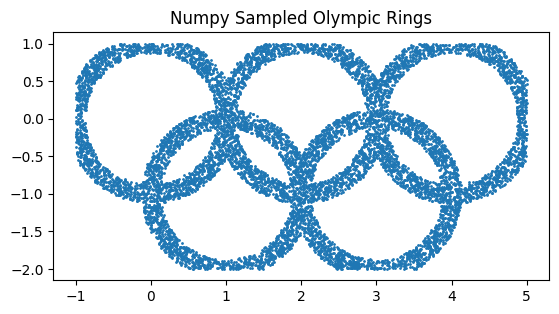

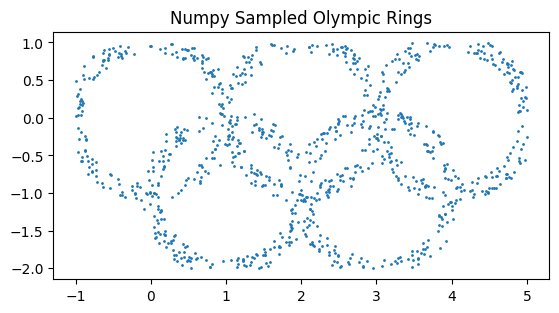

In [ ]:
data_set = MyDataset(create_unconditional_olympic_rings(250000))
data_loader = data.DataLoader(data_set, batch_size=128, shuffle=True)
validation_set = torch.from_numpy(create_unconditional_olympic_rings(1000)).to(torch.float32)

In [ ]:
model = NormalizingFlow(5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
record_data = train(model, optimizer, data_loader, validation_set, scheduler, 20)

## Q1: Loss.
Present the validation loss over the training epochs. Additionally, plot the log-determinant and the
log(pz(x)) components of this loss in separate lines at the same figure.

In [ ]:
px.line(record_data, y="loss", title='Loss').show()
px.line(record_data, y=["log_det", "log_pz"], title="Loss").show()

##  Q2: Sampling.
Present a 3 figures with different samplings of 1000 points, using 3 different seeds

In [ ]:
for seed in [18,26,42]:
    torch.random.manual_seed(seed)
    z = torch.randn(1000, 2,device=device)
    out = model(z).detach().cpu()
    px.scatter(x=out[:,0], y=out[:,1]).show()


##  Q3: Sampling over time.
Your Normalizing flow model should keep the dimension of the input at all times. Sample
1000 points out of it, and plot them after each layer of the model (in separate figures) showing how the distribution
progresses. Please plot up to 6 figures, if your model has more than 5 layers, choose a layer at every 1/5 of the way
from your model

In [ ]:
z = torch.randn(1000, 2,device=device)
out = model.forward_and_plot(z)
fig = go.Figure()
colors = px.colors.qualitative.Plotly[:10]
relevant_layers = [0, 2, 4, 6, 8,9]
fig = go.Figure()
for i in relevant_layers:
    fig.add_trace(
        go.Scatter(
            x=out[i, :, 0],
            y=out[i, :, 1],
            mode="markers",
            name=f"layer: {i}",
            marker=dict(size=7),
        )
    )
fig.show()


## Q4: Sampling trajectories.
Sample 10 points from your model and present the forward process of them layer by
layer, as a trajectory in a 2D space. Color the points according to their time t.

In [ ]:
model = NormalizingFlow(5).to(device)
model.load_state_dict(torch.load("/content/normlizeV2.pt"))
model.eval()

In [9]:
z = torch.randn(10, 2, device=device)
out =model.forward_and_plot(z)

In [10]:
# helped by chatgpt 🙌
colors = px.colors.qualitative.Plotly[:10]
relevant_layers = [0, 2, 4,6 , 8,9]

fig = go.Figure()
for i in range(out.size(1)):
    fig.add_trace(
        go.Scatter(
            x=out[relevant_layers, i, 0],
            y=out[relevant_layers, i, 1],
            mode="lines+markers",
            name=f"point {i}",
            marker=dict(size=7, color=colors[:6]),
            line={"width": 0.3, "color": colors[i % len(colors)]},
        )
    )
fig.show()


In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_point_trajectories(model, num_points=10):
    model.eval()
    z = torch.randn(num_points, 2, device=device)
    out = model.forward_and_plot(z)
    colors = px.colors.qualitative.Plotly[:num_points]
    relevant_layers = [0, 2, 4, 6, 8, 9]

    # Create a subplot for each point
    fig = make_subplots(
        rows=2,
        cols=5,
        subplot_titles=[f"Point {i+1}" for i in range(num_points)],
        horizontal_spacing=0.02,  # Decrease horizontal spacing
        vertical_spacing=0.06,    # Decrease vertical spacing
    )

    for i in range(num_points):
        row = i // 5 + 1
        col = i % 5 + 1

        fig.add_trace(
            go.Scatter(
                x=out[relevant_layers, i, 0],
                y=out[relevant_layers, i, 1],
                mode="lines+markers",
                marker=dict(size=7, color=colors[:6]),
                line={"width": 0.3, "color":"black"},
                showlegend=False,  # Remove trace name from legend
                text = [f"layer {layer} point {i}" for layer in relevant_layers]
            ),
            row=row, col=col
        )

        # Update axes labels, range, and make square
        fig.update_xaxes(title_text="X", row=row, col=col, range=[-3, 3], scaleanchor="y", scaleratio=1)
        fig.update_yaxes(title_text="Y", row=row, col=col, range=[-3, 3])

    # Update layout
    fig.update_layout(
        height=600,  # Adjust height to make subplots more square
        width=1200,  # Adjust width to make subplots more square
        title_text="Point Trajectories",
        showlegend=False,  # Remove legend
    )
    fig.show()

# Call the function
plot_point_trajectories(model)

##  Q5: Probability estimation.
For 5 points of your choice, present the inverse process layer by layer, as a trajectory
in a 2D space.
Choose 3 points from inside the olympic logo and 2 outside of it. Color the points according to their
time t. Compute the log(pz(x)) of both points. Are the points inside the Olympic logo more or less likely from
outside of it? Why? Explain.

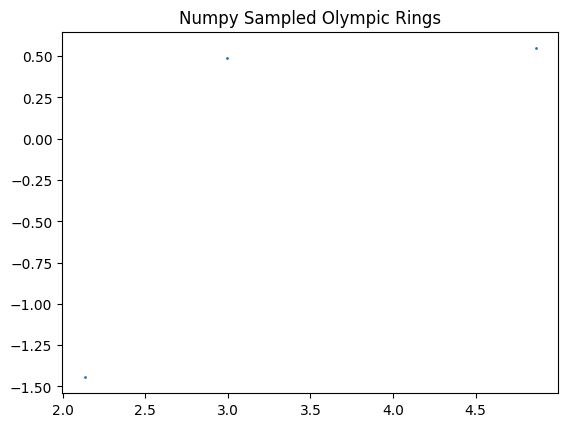

In [ ]:
points_on_ring = torch.from_numpy(create_unconditional_olympic_rings(3).astype(np.float32))
point_out_ring = torch.tensor([[-0.5, -1.], [0.5, -1.]])
points = torch.cat([points_on_ring, point_out_ring], dim=0)
px.scatter(x=points[:, 0], y=points[:,1]).show()
out = model.inverse_and_plot(points.to(device)).detach()


In [ ]:
# helped by chatgpt ✡️
colors = px.colors.qualitative.Plotly[:10]
relevant_layers = [0, 2, 4, 6, 8]
in_or_out = lambda i: "in_range" if i < 3 else "out_ring"
fig = go.Figure()
for i in range(out.size(1)):
    fig.add_trace(
        go.Scatter(
            x=out[relevant_layers, i, 0],
            y=out[relevant_layers, i, 1],
            mode="lines+markers",
            name=f"{i}:{in_or_out(i)}",
            marker=dict(size=7, color=colors[:5]),
            line=dict(width=0.3,color="#000000"),
            text = [f"layer {layer} point {i}" for layer in relevant_layers]
        )
    )
fig.show()

In [ ]:
normal_model = torch.distributions.MultivariateNormal(torch.zeros(2,device=device), torch.eye(2,device=device))
inverse_points = model.inverse(points.to(device))
log_prob = normal_model.log_prob(inverse_points)
print(log_prob)

tensor([-7.0820, -2.6858, -2.8925, -8.9323, -2.1670], device='cuda:0',
       grad_fn=<SubBackward0>)
